# Feature Selection Experiments for openSMILE

The [openSMILE Python API](https://audeering.github.io/opensmile-python/) includes the [ComParE 2016](http://www.tangsoo.de/documents/Publications/Schuller16-TI2.pdf) feature set which enables us to extract 65 low-level descriptors (for ex. MFCC) as well as 6373 Functionals derived from these decriptors. 

For each audio file - the LLDs are a `samples x 65` df and the functionals are a `1 x 6373` df. 

In these experiments, we extract the functionals for both real and fake audio data and run a set of feature selection techniques to identify a hnadful subset of features for use in a final predictive model.

# Import Statements

In [1]:
import opensmile 
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import svm
from pprint import pprint
from tqdm import tqdm
base_path = "/home/ubuntu/"

# Experimental Data

To save time, the data is sampled and features are extracted using openSMILE in a separate notebook `sampling_and_mixing_data.ipynb` and saved in `.csv` format for reusability. The dataset used contains original audio from the [LJSpeech 1.1](https://keithito.com/LJ-Speech-Dataset/) dataset and fake audio generated using GANs for the [NeurIPS 2021 WaveFake](https://arxiv.org/abs/2111.02813) dataset. It also contains audio from LJSpeech generated using ElevenLabs.

Contains 12,800 audio files - 6400 each real and fake with a set of 800 real audio files matching a set of the same 800 fakes generated using one of the archs listed below. 

## Loading and Summary

In [2]:
exp_data_file = '/home/ubuntu/testing-code/opensmile-feature-importance/smile_dfs/0310-lj_experimental_data_v1.csv'
exp_data_df = pd.read_csv(exp_data_file)

In [3]:
exp_data_df.head()

,id,file,type,fake,duration(seconds),audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,LJ032-0137,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,7.762,2.529597,0.608866,0.765319,0.343702,0.589645,...,10.773912,0.657822,2.936347,2.935397,20.000000,0.609994,129.240130,64.158455,130.97571,60.847908
1,LJ038-0165,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,8.656,2.406416,0.005841,0.695093,0.295922,0.514596,...,8.458103,0.531263,2.910538,2.911863,-20.000000,0.650057,125.028530,58.838596,115.42761,55.276188
2,LJ044-0203,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,5.150,2.695161,0.249012,0.175889,0.375376,0.674925,...,11.555664,0.663116,2.731076,2.731820,-20.000000,0.479881,126.260170,54.306473,109.07703,62.240750
3,LJ003-0044,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,3.199,2.287197,0.528846,0.996795,0.478625,0.801715,...,11.162925,0.497092,3.827386,3.820832,19.997963,0.526514,155.382830,77.223274,146.11166,88.627940
4,LJ036-0116,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,2.340,2.027513,0.181416,0.513274,0.277241,0.572403,...,6.160469,0.462080,2.797420,2.774368,19.579084,0.638266,99.164055,44.689617,123.44574,49.456890


In [4]:
exp_data_df.shape

(12800, 6378)

In [5]:
exp_data_df.type.value_counts()

ElevenLabs           1600
Waveglow             1600
Parallel_WaveGan     1600
Multi_Band_MelGan    1600
MelGanLarge          1600
MelGan               1600
HifiGan              1600
Full_Band_MelGan     1600
Name: type, dtype: int64

In [6]:
#check to ensure each id has a corresponding fake
exp_data_df.id.value_counts()

LJ032-0137    2
LJ038-0118    2
LJ046-0168    2
LJ016-0171    2
LJ037-0020    2
             ..
LJ004-0171    2
LJ042-0184    2
LJ015-0150    2
LJ007-0172    2
LJ028-0069    2
Name: id, Length: 6400, dtype: int64

## Train-Dev-Test Split:

In [7]:
#split data based on unique id which has a real fake pair after shuffling
id_list = exp_data_df.id.unique()
np.random.shuffle(id_list)

In [8]:
#split the data 
f1 = 0.8
f2 = 0.9
train_ids, dev_ids, test_ids = np.split(id_list, [int(f1*len(id_list)), int(f2*len(id_list))])

In [9]:
#check split
len(train_ids), len(dev_ids), len(test_ids), (len(train_ids) + len(dev_ids) + len(test_ids))

(5120, 640, 640, 6400)

In [10]:
train_df = exp_data_df[exp_data_df.id.isin(train_ids)].sample(frac=1).reset_index(drop=True)
dev_df = exp_data_df[exp_data_df.id.isin(dev_ids)].sample(frac=1).reset_index(drop=True)
test_df = exp_data_df[exp_data_df.id.isin(test_ids)].sample(frac=1).reset_index(drop=True)

In [11]:
train_df.type.value_counts()

HifiGan              1300
MelGanLarge          1298
Multi_Band_MelGan    1286
Full_Band_MelGan     1284
Waveglow             1276
MelGan               1270
ElevenLabs           1264
Parallel_WaveGan     1262
Name: type, dtype: int64

In [12]:
dev_df.type.value_counts()

Parallel_WaveGan     186
ElevenLabs           178
Waveglow             178
MelGan               166
MelGanLarge          154
Full_Band_MelGan     152
HifiGan              138
Multi_Band_MelGan    128
Name: type, dtype: int64

In [13]:
test_df.type.value_counts()

Multi_Band_MelGan    186
Full_Band_MelGan     164
MelGan               164
HifiGan              162
ElevenLabs           158
Parallel_WaveGan     152
MelGanLarge          148
Waveglow             146
Name: type, dtype: int64

__Feature Scaling:__

In [14]:
exp_data_scaler = StandardScaler()
train_df.iloc[:,5:] = exp_data_scaler.fit_transform(train_df.iloc[:,5:])
dev_df.iloc[:,5:] = exp_data_scaler.transform(dev_df.iloc[:,5:])
test_df.iloc[:,5:] = exp_data_scaler.transform(test_df.iloc[:,5:])

In [15]:
X_train = train_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_train = train_df['fake'].copy()

X_dev = dev_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_dev = dev_df['fake'].copy()

X_train_final = pd.concat([X_train, X_dev])
y_train_final = pd.concat([y_train, y_dev])

X_test = test_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_test = test_df['fake'].copy()

# Experiment 1: Brute Force Feature Selection

In the first experiment, we break down the data set into each architecture used to generate fakes 

## Brute Force Selection

In [16]:
def run_bflr_for_arch(train_df, dev_df, arch, all_archs=False):
    
    #prepare data
    if all_archs==False:
        trdf = train_df[train_df.type==arch]
    if all_archs==True:
        trdf = train_df[train_df.type.isin(arch)]
    
    if all_archs==False:
        dvdf = dev_df[dev_df.type==arch]
    if all_archs==True:
        dvdf = dev_df[dev_df.type.isin(arch)]
    
    X_train = trdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
    y_train = trdf['fake'].copy()
    
    X_dev = dvdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
    y_dev = dvdf['fake'].copy()
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(6373)):
        
        model_lr = LogisticRegression()
        model_lr.fit(X_train.iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_lr.predict(X_train.iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_lr.predict(X_dev.iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies

In [17]:
archs = list(exp_data_df.type.unique())
features = train_df.columns.to_list()[5:]
bruteforce_df = pd.DataFrame(features, columns=['features'])

for arch in archs:
    print("\nRunning for {} architecture\n".format(arch))
    bruteforce_df[arch] = run_bflr_for_arch(train_df, dev_df, arch)

print("\nRunning for all architectures\n")
bruteforce_df['all_archs'] = run_bflr_for_arch(train_df, dev_df, archs, all_archs=True)


Running for ElevenLabs architecture



100%|██████████| 6373/6373 [00:13<00:00, 486.22it/s]



Average train accuracy: 0.624516726021765
Average dev accuracy: 0.6205745093856279


Running for Waveglow architecture



100%|██████████| 6373/6373 [00:11<00:00, 539.14it/s]



Average train accuracy: 0.5289789113260439
Average dev accuracy: 0.5281383716768601


Running for Parallel_WaveGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 539.02it/s]



Average train accuracy: 0.5282884186282114
Average dev accuracy: 0.5265915176424736


Running for Multi_Band_MelGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 544.27it/s]



Average train accuracy: 0.5240643910119456
Average dev accuracy: 0.5244414914482975


Running for MelGanLarge architecture



100%|██████████| 6373/6373 [00:11<00:00, 538.97it/s]



Average train accuracy: 0.5273957665681756
Average dev accuracy: 0.5254992144212293


Running for MelGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 544.25it/s]



Average train accuracy: 0.522693301341412
Average dev accuracy: 0.5209798869099496


Running for HifiGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 541.07it/s]



Average train accuracy: 0.5157499788772345
Average dev accuracy: 0.5145882652585523


Running for Full_Band_MelGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 550.13it/s]



Average train accuracy: 0.5125791097860767
Average dev accuracy: 0.5105585240364366


Running for all architectures



100%|██████████| 6373/6373 [00:26<00:00, 240.96it/s]


Average train accuracy: 0.5172472001019928
Average dev accuracy: 0.5175658049584183



#### Analysis Tables and Feature Selection

In [18]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.95).any(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
2,audspec_lengthL1norm_sma_minPos,0.966292,0.500000,0.516129,0.492188,0.506494,0.481928,0.500000,0.526316,0.538281
12,audspec_lengthL1norm_sma_stddev,0.955056,0.601124,0.639785,0.546875,0.532468,0.518072,0.601449,0.572368,0.485938
64,pcm_RMSenergy_sma_minPos,0.966292,0.505618,0.505376,0.507812,0.500000,0.481928,0.492754,0.546053,0.532031
93,pcm_zcr_sma_range,1.000000,0.539326,0.532258,0.617188,0.538961,0.493976,0.507246,0.526316,0.566406
96,pcm_zcr_sma_quartile1,1.000000,0.516854,0.521505,0.546875,0.487013,0.530120,0.500000,0.552632,0.546875
97,pcm_zcr_sma_quartile2,0.994382,0.522472,0.494624,0.578125,0.519481,0.536145,0.485507,0.486842,0.528906
102,pcm_zcr_sma_percentile1.0,0.977528,0.544944,0.543011,0.640625,0.448052,0.500000,0.543478,0.532895,0.517188
103,pcm_zcr_sma_percentile99.0,1.000000,0.505618,0.532258,0.562500,0.551948,0.500000,0.550725,0.526316,0.555469
104,pcm_zcr_sma_pctlrange0-1,1.000000,0.505618,0.521505,0.585938,0.545455,0.493976,0.543478,0.526316,0.564063
105,pcm_zcr_sma_stddev,0.983146,0.528090,0.505376,0.523438,0.519481,0.518072,0.521739,0.506579,0.545312


In [19]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1701,mfcc_sma[6]_lpc1,0.730337,0.561798,0.618280,0.570312,0.883117,0.873494,0.572464,0.605263,0.645312
2945,pcm_fftMag_spectralFlux_sma_de_range,0.741573,0.556180,0.666667,0.625000,0.571429,0.572289,0.557971,0.572368,0.551562
2956,pcm_fftMag_spectralFlux_sma_de_pctlrange0-1,0.842697,0.550562,0.736559,0.703125,0.577922,0.620482,0.579710,0.565789,0.570312
2957,pcm_fftMag_spectralFlux_sma_de_stddev,0.870787,0.578652,0.774194,0.742188,0.584416,0.644578,0.601449,0.565789,0.571875
3776,jitterDDP_sma_flatness,0.668539,0.735955,0.666667,0.789062,0.623377,0.734940,0.724638,0.651316,0.657031
6030,pcm_fftMag_spectralFlux_sma_de_rqmean,0.876404,0.584270,0.779570,0.742188,0.584416,0.644578,0.601449,0.565789,0.571094


In [20]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
3776,jitterDDP_sma_flatness,0.668539,0.735955,0.666667,0.789062,0.623377,0.73494,0.724638,0.651316,0.657031


In [21]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
5,audspec_lengthL1norm_sma_quartile3,0.926966,0.606742,0.720430,0.578125,0.564935,0.554217,0.572464,0.578947,0.467969
87,pcm_RMSenergy_sma_lpgain,0.500000,0.556180,0.704301,0.703125,0.564935,0.554217,0.572464,0.559211,0.578906
1265,pcm_fftMag_spectralFlux_sma_lpgain,0.938202,0.561798,0.709677,0.671875,0.584416,0.596386,0.594203,0.552632,0.460156
1701,mfcc_sma[6]_lpc1,0.730337,0.561798,0.618280,0.570312,0.883117,0.873494,0.572464,0.605263,0.645312
2945,pcm_fftMag_spectralFlux_sma_de_range,0.741573,0.556180,0.666667,0.625000,0.571429,0.572289,0.557971,0.572368,0.551562
2956,pcm_fftMag_spectralFlux_sma_de_pctlrange0-1,0.842697,0.550562,0.736559,0.703125,0.577922,0.620482,0.579710,0.565789,0.570312
2957,pcm_fftMag_spectralFlux_sma_de_stddev,0.870787,0.578652,0.774194,0.742188,0.584416,0.644578,0.601449,0.565789,0.571875
3751,jitterLocal_sma_quartile1,0.494382,0.651685,0.639785,0.742188,0.551948,0.698795,0.594203,0.592105,0.621094
3757,jitterLocal_sma_percentile1.0,0.533708,0.719101,0.709677,0.851562,0.655844,0.753012,0.688406,0.697368,0.681250
3776,jitterDDP_sma_flatness,0.668539,0.735955,0.666667,0.789062,0.623377,0.734940,0.724638,0.651316,0.657031


In [22]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1763,mfcc_sma[8]_lpc1,0.578652,0.511236,0.505376,0.585938,0.948052,0.915663,0.565217,0.572368,0.612500
1794,mfcc_sma[9]_lpc1,0.612360,0.511236,0.456989,0.507812,0.948052,0.879518,0.565217,0.605263,0.587500
1824,mfcc_sma[10]_lpc0,0.814607,0.567416,0.500000,0.507812,0.915584,0.849398,0.507246,0.625000,0.612500
1825,mfcc_sma[10]_lpc1,0.662921,0.516854,0.451613,0.515625,0.915584,0.879518,0.536232,0.625000,0.613281
1854,mfcc_sma[11]_lpgain,0.640449,0.601124,0.666667,0.609375,0.909091,0.837349,0.550725,0.519737,0.602344
1855,mfcc_sma[11]_lpc0,0.893258,0.500000,0.569892,0.562500,0.909091,0.903614,0.521739,0.526316,0.610156
1856,mfcc_sma[11]_lpc1,0.735955,0.556180,0.532258,0.507812,0.902597,0.921687,0.586957,0.592105,0.622656
1885,mfcc_sma[12]_lpgain,0.747191,0.556180,0.607527,0.640625,0.902597,0.849398,0.579710,0.506579,0.574219
1886,mfcc_sma[12]_lpc0,0.808989,0.578652,0.575269,0.585938,0.909091,0.879518,0.557971,0.467105,0.592969
1887,mfcc_sma[12]_lpc1,0.696629,0.443820,0.559140,0.539062,0.896104,0.939759,0.565217,0.585526,0.607031


In [23]:
bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
66,pcm_RMSenergy_sma_quartile2,0.674157,0.550562,0.666667,0.671875,0.545455,0.542169,0.615942,0.592105,0.606250
1575,mfcc_sma[2]_lpgain,0.792135,0.651685,0.612903,0.546875,0.642857,0.614458,0.536232,0.539474,0.608594
1576,mfcc_sma[2]_lpc0,0.814607,0.584270,0.553763,0.570312,0.681818,0.620482,0.572464,0.506579,0.602344
1577,mfcc_sma[2]_lpc1,0.691011,0.606742,0.548387,0.578125,0.727273,0.704819,0.565217,0.532895,0.614062
1606,mfcc_sma[3]_lpgain,0.573034,0.629213,0.591398,0.500000,0.701299,0.728916,0.543478,0.565789,0.600781
1607,mfcc_sma[3]_lpc0,0.691011,0.522472,0.559140,0.539062,0.792208,0.783133,0.543478,0.526316,0.613281
1608,mfcc_sma[3]_lpc1,0.589888,0.539326,0.532258,0.585938,0.831169,0.825301,0.543478,0.546053,0.620313
1639,mfcc_sma[4]_lpc1,0.668539,0.500000,0.500000,0.523438,0.844156,0.825301,0.594203,0.506579,0.603906
1669,mfcc_sma[5]_lpc0,0.853933,0.516854,0.510753,0.523438,0.831169,0.819277,0.565217,0.565789,0.612500
1670,mfcc_sma[5]_lpc1,0.786517,0.505618,0.505376,0.531250,0.870130,0.873494,0.644928,0.618421,0.642969


In [24]:
max_idxs = []
for arch in archs + ['all_archs']:
    max_idxs.append(bruteforce_df[arch].idxmax())
bruteforce_df[bruteforce_df.index.isin(max_idxs)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
93,pcm_zcr_sma_range,1.000000,0.539326,0.532258,0.617188,0.538961,0.493976,0.507246,0.526316,0.566406
1763,mfcc_sma[8]_lpc1,0.578652,0.511236,0.505376,0.585938,0.948052,0.915663,0.565217,0.572368,0.612500
1887,mfcc_sma[12]_lpc1,0.696629,0.443820,0.559140,0.539062,0.896104,0.939759,0.565217,0.585526,0.607031
3790,jitterDDP_sma_quartile1,0.539326,0.865169,0.747312,0.890625,0.584416,0.795181,0.789855,0.736842,0.727344
6030,pcm_fftMag_spectralFlux_sma_de_rqmean,0.876404,0.584270,0.779570,0.742188,0.584416,0.644578,0.601449,0.565789,0.571094


In [25]:
feats_lr_1 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)].features.to_list()
feats_lr_2 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)].features.to_list()
feats_lr_3 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)].features.to_list()
feats_lr_4 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)].features.to_list()
feats_lr_5 = bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)].features.to_list()
feats_lr_6 = bruteforce_df[bruteforce_df.index.isin(max_idxs)].features.to_list()

exp_1_feature_set = set().union(feats_lr_1, feats_lr_2, feats_lr_3, feats_lr_4, feats_lr_5, feats_lr_6)

In [26]:
selected_features = list(exp_1_feature_set)

In [27]:
exp_1_feature_set

{'audspec_lengthL1norm_sma_amean',
 'audspec_lengthL1norm_sma_quartile3',
 'jitterDDP_sma_de_flatness',
 'jitterDDP_sma_flatness',
 'jitterDDP_sma_percentile1.0',
 'jitterDDP_sma_quartile1',
 'jitterDDP_sma_quartile2',
 'jitterLocal_sma_percentile1.0',
 'jitterLocal_sma_quartile1',
 'mfcc_sma[10]_lpc0',
 'mfcc_sma[10]_lpc1',
 'mfcc_sma[11]_lpc0',
 'mfcc_sma[11]_lpc1',
 'mfcc_sma[11]_lpgain',
 'mfcc_sma[12]_lpc0',
 'mfcc_sma[12]_lpc1',
 'mfcc_sma[12]_lpgain',
 'mfcc_sma[13]_lpc0',
 'mfcc_sma[13]_lpc1',
 'mfcc_sma[2]_lpc0',
 'mfcc_sma[2]_lpc1',
 'mfcc_sma[2]_lpgain',
 'mfcc_sma[3]_lpc0',
 'mfcc_sma[3]_lpc1',
 'mfcc_sma[3]_lpgain',
 'mfcc_sma[4]_lpc1',
 'mfcc_sma[5]_lpc0',
 'mfcc_sma[5]_lpc1',
 'mfcc_sma[6]_lpc0',
 'mfcc_sma[6]_lpc1',
 'mfcc_sma[7]_lpc0',
 'mfcc_sma[7]_lpc1',
 'mfcc_sma[8]_lpc0',
 'mfcc_sma[8]_lpc1',
 'mfcc_sma[9]_lpc0',
 'mfcc_sma[9]_lpc1',
 'mfcc_sma[9]_lpgain',
 'mfcc_sma_de[10]_lpc0',
 'mfcc_sma_de[10]_lpc1',
 'mfcc_sma_de[11]_lpc0',
 'mfcc_sma_de[11]_lpc1',
 'mfcc_sm

In [28]:
len(exp_1_feature_set)

83

#### Correlation Analysis

<AxesSubplot: >

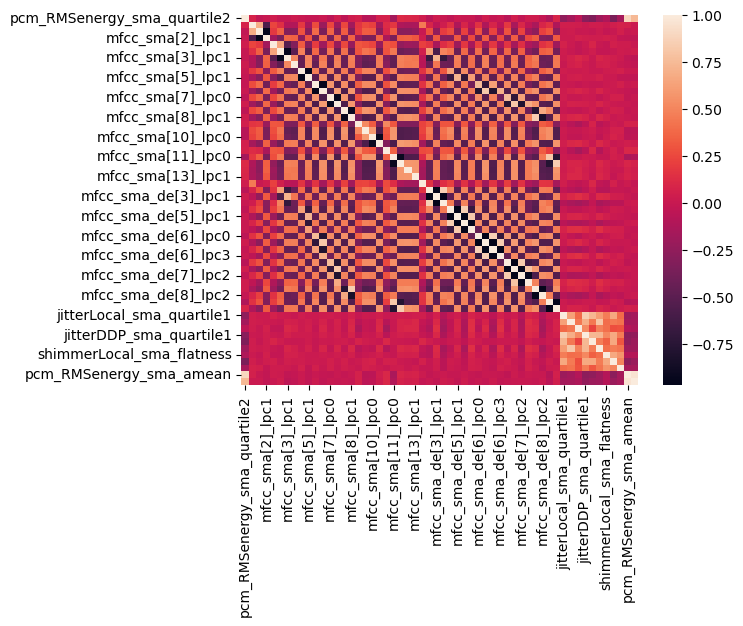

In [29]:
corr_feats_bf = bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)].iloc[:,0].to_list()
corr_feats_idx_bf = train_df.columns.intersection(corr_feats_bf)
corr_df_bf = train_df[corr_feats_idx_bf].corr()
sns.heatmap(corr_df_bf)

## LR on held out test data

In [30]:
#select features identified from brute force
feature_index = train_df.columns.intersection(selected_features)

#fit model
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_final[feature_index], y_train_final)

#predict on held out test data
yhat_train_final_lr = model_lr.predict(X_train_final[feature_index])
yhat_test_lr = model_lr.predict(X_test[feature_index])

#compute accuracy
accuracy_lr_train = accuracy_score(y_train_final, yhat_train_final_lr)
accuracy_lr_test = accuracy_score(y_test, yhat_test_lr)

#print
print('Logistic accuracy train = %.3f' % (accuracy_lr_train*100))
print('Logistic accuracy test = %.3f' % (accuracy_lr_test*100))

Logistic accuracy train = 92.300
Logistic accuracy test = 90.234


#### Confusion Matrix

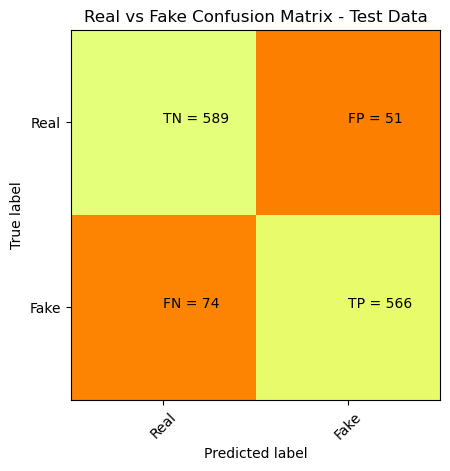

In [31]:
#generate confusion matrix
cm_lr_final = confusion_matrix(y_test, yhat_test_lr)

#plot confusion matrix
plt.imshow(cm_lr_final, interpolation='nearest', cmap=plt.cm.Wistia_r)
classNames = ['Real','Fake']
plt.title('Real vs Fake Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_lr_final[i][j]))
plt.show()

#### ROC curve

In [32]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model_lr.predict_proba(X_test[feature_index])
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.964


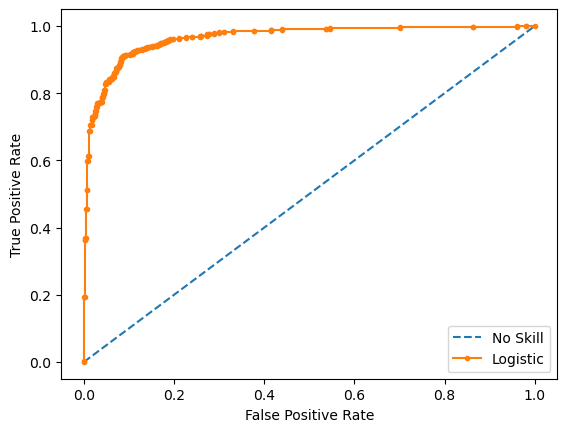

In [33]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## SVM on held out test data

In [34]:
#select features identified from brute force
feature_index = train_df.columns.intersection(selected_features)

#fit model
model_svm = svm.SVC(probability=True)
model_svm.fit(X_train_final[feature_index], y_train_final)

#predict on held out test data
yhat_train_final_svm = model_svm.predict(X_train_final[feature_index])
yhat_test_svm = model_svm.predict(X_test[feature_index])

#compute accuracy
accuracy_svm_train = accuracy_score(y_train_final, yhat_train_final_svm)
accuracy_svm_test = accuracy_score(y_test, yhat_test_svm)

#print
print('SVM accuracy train = %.3f' % (accuracy_svm_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svm_test*100))

SVM accuracy train = 95.191
SVM accuracy test = 90.625


#### Confusion Matrix

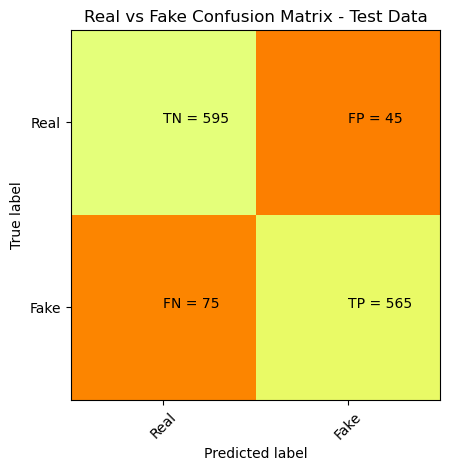

In [35]:
#generate confusion matrix
cm_svm_final = confusion_matrix(y_test, yhat_test_svm)

#plot confusion matrix
plt.imshow(cm_svm_final, interpolation='nearest', cmap=plt.cm.Wistia_r)
classNames = ['Real','Fake']
plt.title('Real vs Fake Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_svm_final[i][j]))
plt.show()

#### ROC curve

In [36]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
svm_probs = model_svm.predict_proba(X_test[feature_index])
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))

No Skill: ROC AUC=0.500
SVM: ROC AUC=0.974


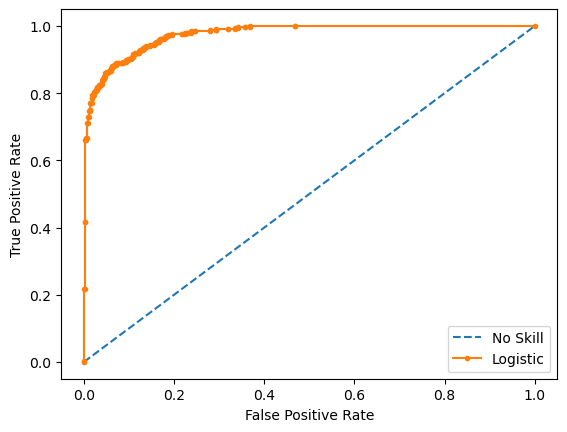

In [37]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(svm_fpr, svm_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Experiment 2: Feature Selection using SelectFromModel

## Model for Feature Selection - Random Forest Classifier(Feature Importance)

(hyperparameters selected based on a random search run in another notebook)

In [38]:
#hyperparameter selection 
n_estimators = 250 #default=100
criterion = "entropy" #{“gini”, “entropy”, “log_loss”}, default=”gini”
max_depth = 25 #default=None 
min_samples_split = 50 #default=2 The minimum number of samples required to split an internal node
min_samples_leaf = 10 #default=1 The minimum number of samples required to be at a leaf node.
max_features = "sqrt" #default="sqrt" The number of features to consider when looking for the best split:
bootstrap = True #default = True Whether bootstrap samples are used when building trees.
n_jobs = -1 #default=None -1 means all processors

In [39]:
#define model
"""model_rfc = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    criterion=criterion,
                                    max_features=max_features,
                                    bootstrap=bootstrap,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    n_jobs=n_jobs)"""

                            
model_rfc = RandomForestClassifier()
#fit model
model_rfc.fit(X_train, y_train)

#get feature importance 
importance = model_rfc.feature_importances_

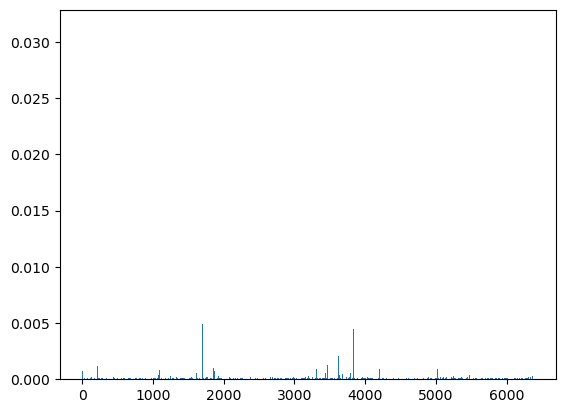

In [40]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [41]:
#accuracy on dev set
y_hat_rf_train = model_rfc.predict(X_train)
y_hat_rf_dev = model_rfc.predict(X_dev)
accuracy_rf_train = accuracy_score(y_train, y_hat_rf_train)
accuracy_rf_dev = accuracy_score(y_dev, y_hat_rf_dev)
print("Training accuracy: %0.2f" % (accuracy_rf_train))
print("Dev accuracy: %0.2f" % (accuracy_rf_dev))

Training accuracy: 1.00
Dev accuracy: 0.88


## Important Features

In [42]:
important_features_dict = {}
features = train_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).columns

for idx, val in enumerate(importance):
    important_features_dict[idx] = val

important_features_list_sorted = sorted(important_features_dict,
                                         key=important_features_dict.get,
                                         reverse=True)

for i, feat_idx in enumerate(important_features_list_sorted[:100]):    
    print("%i) Feature: %s, Score: %.5f" % (i+1, features[feat_idx], important_features_dict[feat_idx]))

1) Feature: jitterDDP_sma_quartile1, Score: 0.03129
2) Feature: jitterDDP_sma_percentile1.0, Score: 0.02779
3) Feature: jitterLocal_sma_percentile1.0, Score: 0.02025
4) Feature: jitterDDP_sma_flatness, Score: 0.01298
5) Feature: jitterDDP_sma_quartile2, Score: 0.00979
6) Feature: jitterLocal_sma_flatness, Score: 0.00621
7) Feature: mfcc_sma_de[12]_lpgain, Score: 0.00610
8) Feature: mfcc_sma[6]_lpc1, Score: 0.00491
9) Feature: shimmerLocal_sma_percentile1.0, Score: 0.00449
10) Feature: mfcc_sma_de[7]_lpc0, Score: 0.00437
11) Feature: jitterLocal_sma_quartile1, Score: 0.00409
12) Feature: mfcc_sma[5]_lpc0, Score: 0.00401
13) Feature: mfcc_sma_de[6]_lpc1, Score: 0.00391
14) Feature: mfcc_sma_de[9]_lpc0, Score: 0.00391
15) Feature: mfcc_sma_de[6]_lpc2, Score: 0.00378
16) Feature: mfcc_sma[6]_lpc0, Score: 0.00376
17) Feature: pcm_zcr_sma_de_percentile1.0, Score: 0.00339
18) Feature: mfcc_sma[5]_lpc1, Score: 0.00339
19) Feature: mfcc_sma_de[10]_lpc0, Score: 0.00337
20) Feature: shimmerLocal_

In [43]:
# feature selection
def select_features(model, X_train, y_train, X_test, max_features=50):
	# configure to select a subset of features
	fs = SelectFromModel(model, max_features=max_features)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [44]:
# feature selection
X_train_fs, X_dev_fs, fs = select_features(model_rfc, X_train, y_train, X_dev)

In [45]:
fidx = fs.get_support()
features[fidx]

Index(['pcm_zcr_sma_quartile1', 'pcm_zcr_sma_de_range',
       'pcm_zcr_sma_de_percentile1.0',
       'pcm_fftMag_spectralFlux_sma_percentile99.0',
       'pcm_fftMag_spectralFlux_sma_pctlrange0-1', 'mfcc_sma[4]_lpc1',
       'mfcc_sma[5]_lpc0', 'mfcc_sma[5]_lpc1', 'mfcc_sma[6]_lpc0',
       'mfcc_sma[6]_lpc1', 'mfcc_sma[7]_lpc1', 'mfcc_sma[9]_lpgain',
       'mfcc_sma[9]_lpc0', 'mfcc_sma[10]_lpc0', 'mfcc_sma[11]_lpgain',
       'mfcc_sma[11]_lpc1', 'mfcc_sma[12]_lpc0', 'mfcc_sma[12]_lpc1',
       'mfcc_sma[14]_lpc0', 'mfcc_sma_de[3]_lpc1', 'mfcc_sma_de[5]_lpc0',
       'mfcc_sma_de[5]_lpc1', 'mfcc_sma_de[5]_lpc3', 'mfcc_sma_de[6]_lpc1',
       'mfcc_sma_de[7]_lpc0', 'mfcc_sma_de[8]_lpc0', 'mfcc_sma_de[8]_lpc2',
       'mfcc_sma_de[9]_lpc0', 'mfcc_sma_de[9]_lpc2', 'mfcc_sma_de[10]_lpc0',
       'mfcc_sma_de[10]_lpc1', 'mfcc_sma_de[11]_lpgain',
       'mfcc_sma_de[11]_lpc0', 'mfcc_sma_de[12]_lpc1', 'mfcc_sma_de[12]_lpc2',
       'mfcc_sma_de[13]_lpgain', 'mfcc_sma_de[13]_lpc1',
       '

In [46]:
corr_feats = fs.get_feature_names_out()
corr_feats_index = train_df.columns.intersection(corr_feats)
train_df_corr = train_df[corr_feats_index].corr()

<AxesSubplot: >

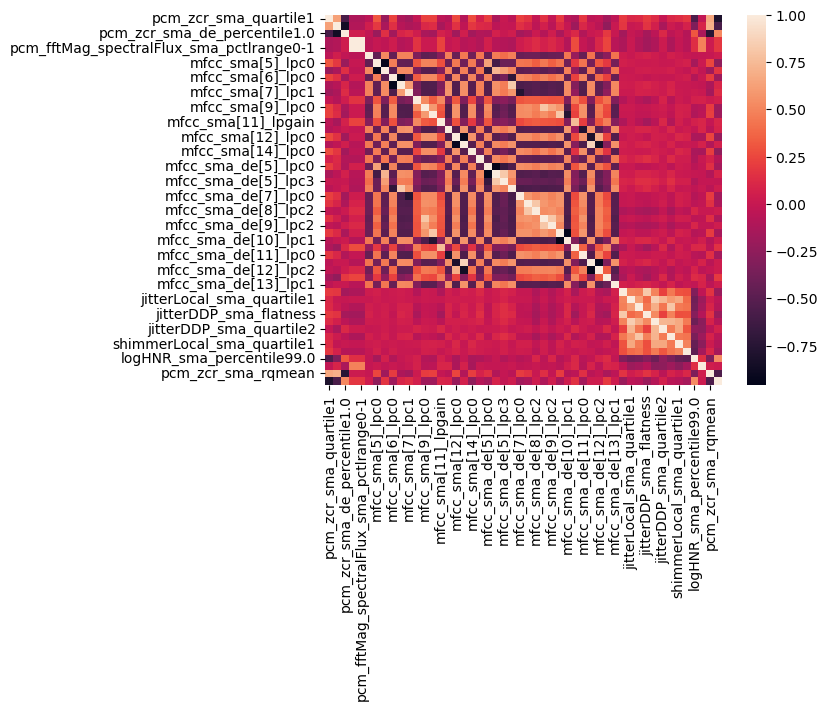

In [47]:
sns.heatmap(train_df_corr)

## Selecting optimal features and model

In [48]:
cellEnabled = 0
#cellEnabled = 1

#select max features
max_features = np.arange(5,100,1)

if cellEnabled:

    lr_accuracies_train = []
    lr_accuracies_dev = []

    knnc_accuracies_train = []
    knnc_accuracies_dev = []

    svm_accuracies_train = []
    svm_accuracies_dev = []
    
    for i in tqdm(range(len(max_features))):

        X_train_fs, X_dev_fs, fs = select_features(model_rfc, X_train, y_train, X_dev, max_features[i])

        # fit the logreg model
        model_lr = LogisticRegression(max_iter=1000)
        model_lr.fit(X_train_fs, y_train)
        # evaluate the model
        yhat_lr_train = model_lr.predict(X_train_fs)
        yhat_lr_dev = model_lr.predict(X_dev_fs)
        # evaluate predictions
        lr_accuracies_train.append(accuracy_score(y_train, yhat_lr_train))
        lr_accuracies_dev.append(accuracy_score(y_dev, yhat_lr_dev))

        #KNN classifier
        model_knnc = KNeighborsClassifier()
        model_knnc.fit(X_train_fs, y_train)
        # evaluate the model
        yhat_knnc_train = model_knnc.predict(X_train_fs)
        yhat_knnc_dev = model_knnc.predict(X_dev_fs)
        # evaluate predictions
        knnc_accuracies_train.append(accuracy_score(y_train, yhat_knnc_train))
        knnc_accuracies_dev.append(accuracy_score(y_dev, yhat_knnc_dev))

        #SVM classifier
        #rbf SVM
        model_svm = svm.SVC()
        #fit the model 
        model_svm.fit(X_train_fs, y_train)
        # evaluate the model
        yhat_svm_train = model_svm.predict(X_train_fs)
        yhat_svm_dev = model_svm.predict(X_dev_fs)
        # evaluate predictions
        svm_accuracies_train.append(accuracy_score(y_train, yhat_svm_train))
        svm_accuracies_dev.append(accuracy_score(y_dev, yhat_svm_dev))

In [49]:
cellEnabled = 0
#cellEnabled = 1

savefile = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/run_data/' + '0311-exp2_run_data.csv'

if cellEnabled:
    exp2_data = pd.DataFrame()
    exp2_data['lr_accuracies_train'] = lr_accuracies_train[:-1]
    exp2_data['lr_accuracies_dev'] = lr_accuracies_dev[:-1]
    exp2_data['knnc_accuracies_train'] = knnc_accuracies_train[:-1]
    exp2_data['knnc_accuracies_dev'] = knnc_accuracies_dev[:-1]
    exp2_data['svm_accuracies_train'] = svm_accuracies_train
    exp2_data['svm_accuracies_dev'] = svm_accuracies_dev
    
    exp2_data.to_csv(savefile, index=False)
    
exp2_data = pd.read_csv(savefile)

lr_accuracies_train = exp2_data['lr_accuracies_train'].to_list()
lr_accuracies_dev = exp2_data['lr_accuracies_dev'].to_list()

knnc_accuracies_train = exp2_data['knnc_accuracies_train'].to_list()
knnc_accuracies_dev = exp2_data['knnc_accuracies_dev'].to_list()

svm_accuracies_train = exp2_data['svm_accuracies_train'].to_list()
svm_accuracies_dev = exp2_data['svm_accuracies_dev'].to_list()

In [50]:
len(lr_accuracies_train), len(knnc_accuracies_train), len(svm_accuracies_train)

(95, 95, 95)

In [51]:
len(lr_accuracies_dev), len(knnc_accuracies_dev), len(svm_accuracies_dev)

(95, 95, 95)

__Train accuracy plot__

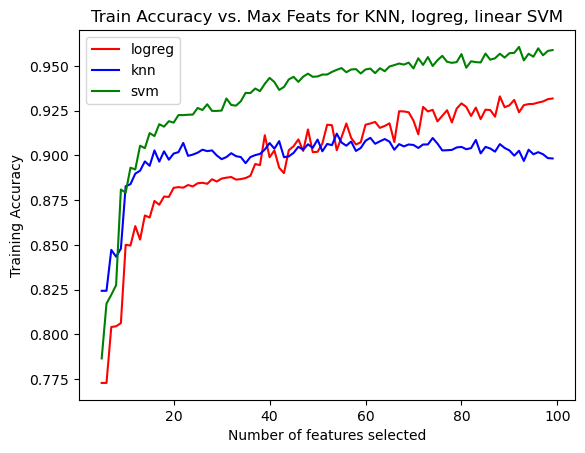

In [52]:
sns.lineplot(x=max_features, y=lr_accuracies_train, color='red', label='logreg')
sns.lineplot(x=max_features, y=knnc_accuracies_train, color='blue', label='knn')
sns.lineplot(x=max_features, y=svm_accuracies_train, color='green', label='svm')
plt.title('Train Accuracy vs. Max Feats for KNN, logreg, linear SVM')
plt.xlabel('Number of features selected')
plt.ylabel('Training Accuracy')
plt.show()

__Dev Accuracy Plot__

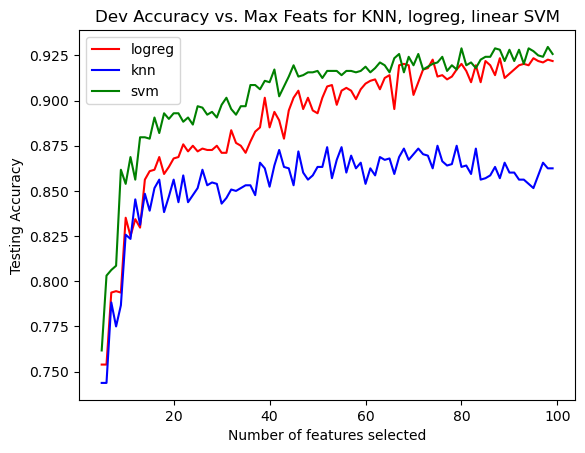

In [53]:
sns.lineplot(x=max_features, y=lr_accuracies_dev, color='red', label='logreg')
sns.lineplot(x=max_features, y=knnc_accuracies_dev, color='blue', label='knn')
sns.lineplot(x=max_features, y=svm_accuracies_dev, color='green', label='svm')
plt.title('Dev Accuracy vs. Max Feats for KNN, logreg, linear SVM')
plt.xlabel('Number of features selected')
plt.ylabel('Testing Accuracy')
plt.show()

## SVM Model With 40 features on held out test data:

In [54]:
X_train_fs, X_test_fs, fs = select_features(model_rfc, X_train_final, y_train_final, X_test, 40)

#SVM classifier
model_svm = svm.SVC(probability=True)
model_svm.fit(X_train_fs, y_train_final)

# evaluate the model
yhat_svm_train = model_svm.predict(X_train_fs)
yhat_svm_test = model_svm.predict(X_test_fs)

#compute accuracy
accuracy_svm_train = accuracy_score(y_train_final, yhat_svm_train)
accuracy_svm_test = accuracy_score(y_test, yhat_svm_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svm_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svm_test*100))

SVM accuracy train = 94.826
SVM accuracy test = 90.000


#### Confusion Matrix:

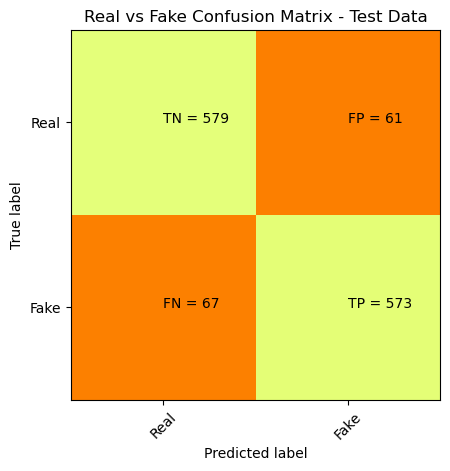

In [55]:
#generate confusion matrix
cm_svm_final = confusion_matrix(y_test, yhat_svm_test)

#plot confusion matrix
plt.imshow(cm_svm_final, interpolation='nearest', cmap=plt.cm.Wistia_r)
classNames = ['Real','Fake']
plt.title('Real vs Fake Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_svm_final[i][j]))
plt.show()

#### ROC Curve:

In [56]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
svm_probs = model_svm.predict_proba(X_test_fs)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))

No Skill: ROC AUC=0.500
SVM: ROC AUC=0.970


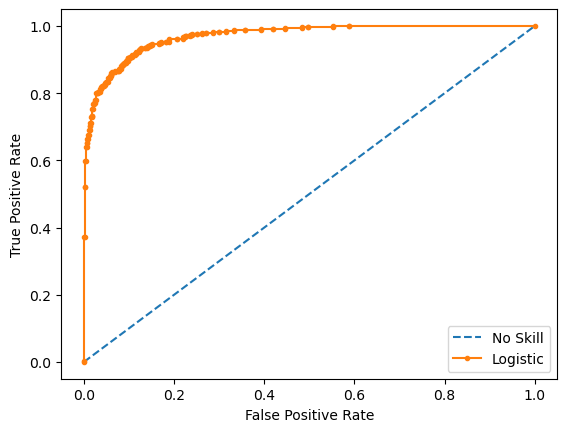

In [57]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(svm_fpr, svm_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Experiment 2 selected features:

In [58]:
exp_2_feature_set = set(fs.get_feature_names_out())

In [59]:
exp_2_feature_set

{'jitterDDP_sma_flatness',
 'jitterDDP_sma_percentile1.0',
 'jitterDDP_sma_quartile1',
 'jitterDDP_sma_quartile2',
 'jitterLocal_sma_flatness',
 'jitterLocal_sma_percentile1.0',
 'jitterLocal_sma_quartile1',
 'mfcc_sma[10]_lpc1',
 'mfcc_sma[12]_lpc0',
 'mfcc_sma[14]_lpgain',
 'mfcc_sma[5]_lpc0',
 'mfcc_sma[6]_lpc1',
 'mfcc_sma[7]_lpc0',
 'mfcc_sma[7]_lpc1',
 'mfcc_sma[8]_lpc1',
 'mfcc_sma[9]_lpc0',
 'mfcc_sma[9]_lpc1',
 'mfcc_sma_de[10]_lpc0',
 'mfcc_sma_de[10]_lpc1',
 'mfcc_sma_de[10]_lpgain',
 'mfcc_sma_de[11]_lpc0',
 'mfcc_sma_de[12]_lpgain',
 'mfcc_sma_de[13]_lpgain',
 'mfcc_sma_de[14]_lpc0',
 'mfcc_sma_de[3]_lpc0',
 'mfcc_sma_de[5]_lpc1',
 'mfcc_sma_de[5]_lpgain',
 'mfcc_sma_de[6]_lpc0',
 'mfcc_sma_de[6]_lpc1',
 'mfcc_sma_de[6]_lpc3',
 'mfcc_sma_de[7]_lpc1',
 'mfcc_sma_de[8]_lpc1',
 'mfcc_sma_de[9]_lpc1',
 'pcm_fftMag_spectralFlux_sma_de_rqmean',
 'pcm_fftMag_spectralFlux_sma_percentile99.0',
 'pcm_zcr_sma_de_pctlrange0-1',
 'pcm_zcr_sma_quartile2',
 'shimmerLocal_sma_flatness',
 

# Experiment 3: Feature Selection using SelectKBest

In [60]:
cellEnabled = 0
#cellEnabled = 1

savefile_e3 = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/run_data/' + '0311-exp3_feats.txt'

if cellEnabled:

    #fit selector 
    e3_selector = SelectKBest(mutual_info_regression, k=100)
    e3_selector.fit(X_train, y_train)
    
    selected_feats_e3 = e3_selector.get_feature_names_out()
    np.savetxt(savefile_e3, selected_feats_e3, fmt='%s')

if not cellEnabled:
    selected_feats_e3 = np.genfromtxt(savefile_e3 ,dtype='str')

In [61]:
exp_3_feature_set = set(selected_feats_e3)

## SVM model with selected features

In [62]:
#select features identified from brute force
feature_index_e3 = train_df.columns.intersection(selected_feats_e3)

#SVM classifier
model_svm_e3 = svm.SVC(probability=True)
model_svm_e3.fit(X_train_final[feature_index_e3], y_train_final)

# evaluate the model
yhat_svme3_train = model_svm_e3.predict(X_train_final[feature_index_e3])
yhat_svme3_test = model_svm_e3.predict(X_test[feature_index_e3])

#compute accuracy
accuracy_svme3_train = accuracy_score(y_train_final, yhat_svme3_train)
accuracy_svme3_test = accuracy_score(y_test, yhat_svme3_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme3_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme3_test*100))

SVM accuracy train = 95.148
SVM accuracy test = 90.625


In [63]:
feature_index_e3

Index(['audspec_lengthL1norm_sma_quartile3', 'pcm_zcr_sma_range',
       'pcm_zcr_sma_quartile1', 'pcm_zcr_sma_quartile2',
       'pcm_zcr_sma_pctlrange0-1', 'pcm_fftMag_spectralEntropy_sma_range',
       'pcm_fftMag_spectralSlope_sma_percentile99.0', 'mfcc_sma[3]_lpc1',
       'mfcc_sma[4]_lpc0', 'mfcc_sma[4]_lpc1', 'mfcc_sma[5]_lpgain',
       'mfcc_sma[5]_lpc0', 'mfcc_sma[5]_lpc1', 'mfcc_sma[6]_lpgain',
       'mfcc_sma[6]_lpc0', 'mfcc_sma[6]_lpc1', 'mfcc_sma[7]_lpgain',
       'mfcc_sma[7]_lpc0', 'mfcc_sma[7]_lpc1', 'mfcc_sma[8]_lpc0',
       'mfcc_sma[8]_lpc1', 'mfcc_sma[9]_lpgain', 'mfcc_sma[9]_lpc0',
       'mfcc_sma[9]_lpc1', 'mfcc_sma[10]_lpgain', 'mfcc_sma[10]_lpc0',
       'mfcc_sma[10]_lpc1', 'mfcc_sma[11]_lpgain', 'mfcc_sma[11]_lpc0',
       'mfcc_sma[11]_lpc1', 'mfcc_sma[12]_lpgain', 'mfcc_sma[12]_lpc0',
       'mfcc_sma[12]_lpc1', 'mfcc_sma[13]_lpgain', 'mfcc_sma[13]_lpc0',
       'mfcc_sma[13]_lpc1', 'mfcc_sma[14]_lpgain', 'mfcc_sma[14]_lpc0',
       'mfcc_sma[14]_lpc1'

# Experiment 4: Running Forward selection 

- on the 100 Features Selected in Experiment 3

In [64]:
cellEnabled = 0
#cellEnabled = 1

savefile_e4 = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/run_data/' + '0312-exp4_feats.txt'

if cellEnabled:
    
    sfs_selector_e4 = SequentialFeatureSelector(estimator=svm.SVC(),
                                                 n_features_to_select=15,
                                                 cv=5,
                                                 direction='forward')

    #select features identified from brute force
    feature_index_e3 = train_df.columns.intersection(selected_feats_e3)

    sfs_selector_e4.fit(X_train_final[feature_index_e3], y_train_final)
    
    selected_feats_e4 = sfs_selector_e4.get_feature_names_out()
    np.savetxt(savefile_e4, selected_feats_e4, fmt='%s')

if not cellEnabled:
    selected_feats_e4 = np.genfromtxt(savefile_e4, dtype='str')

In [65]:
selected_feats_e4

array(['pcm_zcr_sma_range', 'mfcc_sma[6]_lpc0', 'mfcc_sma[6]_lpc1',
       'mfcc_sma_de[5]_lpc2', 'mfcc_sma_de[6]_lpgain',
       'mfcc_sma_de[8]_lpc2', 'mfcc_sma_de[9]_lpgain',
       'mfcc_sma_de[9]_lpc2', 'mfcc_sma_de[13]_lpgain',
       'mfcc_sma_de[14]_lpgain', 'jitterLocal_sma_quartile1',
       'jitterDDP_sma_flatness', 'jitterDDP_sma_quartile1',
       'jitterDDP_sma_percentile1.0', 'audspec_lengthL1norm_sma_amean'],
      dtype='<U30')

## Running SVM

In [66]:
#select features identified from brute force
feature_index_e4 = train_df.columns.intersection(selected_feats_e4)

#SVM classifier
model_svm_e4 = svm.SVC(probability=True)
model_svm_e4.fit(X_train_final[feature_index_e4], y_train_final)

# evaluate the model
yhat_svme4_train = model_svm_e4.predict(X_train_final[feature_index_e4])
yhat_svme4_test = model_svm_e4.predict(X_test[feature_index_e4])

#compute accuracy
accuracy_svme4_train = accuracy_score(y_train_final, yhat_svme4_train)
accuracy_svme4_test = accuracy_score(y_test, yhat_svme4_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme4_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme4_test*100))

SVM accuracy train = 92.960
SVM accuracy test = 90.156


# Experiment 5: Hand selecting features and ablations

This set of experiments show us that the MFCC features combined with Jitter and Shimmer are the best set of features for the SVM classification model.

In [67]:
#get a list of all features for analysis
all_feats = train_df.columns[5:]
len(all_feats)

6373

#### Exp 5(a): All MFCC features 

In [68]:
mfcc_feats = [feat for feat in all_feats if 'mfcc' in feat and 'lp' in feat]
len(mfcc_feats)

168

In [69]:
#select features identified from brute force
feature_index_e5a = train_df.columns.intersection(mfcc_feats)

#SVM classifier
model_svm_e5a = svm.SVC(probability=True)
model_svm_e5a.fit(X_train_final[feature_index_e5a], y_train_final)

# evaluate the model
yhat_svme5a_train = model_svm_e5a.predict(X_train_final[feature_index_e5a])
yhat_svme5a_test = model_svm_e5a.predict(X_test[feature_index_e5a])

#compute accuracy
accuracy_svme5a_train = accuracy_score(y_train_final, yhat_svme5a_train)
accuracy_svme5a_test = accuracy_score(y_test, yhat_svme5a_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5a_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5a_test*100))

SVM accuracy train = 86.224
SVM accuracy test = 79.297


#### Exp 5(b): No derivative MFCC features 

In [70]:
mfcc_feats_2 = [feat for feat in all_feats if 'mfcc' in feat and 'lp' in feat and 'de' not in feat]
len(mfcc_feats_2)

84

In [71]:
#select features identified from brute force
feature_index_e5b = train_df.columns.intersection(mfcc_feats_2)

#SVM classifier
model_svm_e5b = svm.SVC(probability=True)
model_svm_e5b.fit(X_train_final[feature_index_e5b], y_train_final)

# evaluate the model
yhat_svme5b_train = model_svm_e5b.predict(X_train_final[feature_index_e5b])
yhat_svme5b_test = model_svm_e5b.predict(X_test[feature_index_e5b])

#compute accuracy
accuracy_svme5b_train = accuracy_score(y_train_final, yhat_svme5b_train)
accuracy_svme5b_test = accuracy_score(y_test, yhat_svme5b_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5b_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5b_test*100))

SVM accuracy train = 84.670
SVM accuracy test = 76.641


#### Exp 5(c): Only derivative MFCC features 

In [72]:
mfcc_feats_3 = [feat for feat in all_feats if 'mfcc' in feat and 'lp' in feat and 'de' in feat]
len(mfcc_feats_3)

84

In [73]:
#select features identified from brute force
feature_index_e5c = train_df.columns.intersection(mfcc_feats_3)

#SVM classifier
model_svm_e5c = svm.SVC(probability=True)
model_svm_e5c.fit(X_train_final[feature_index_e5c], y_train_final)

# evaluate the model
yhat_svme5c_train = model_svm_e5c.predict(X_train_final[feature_index_e5c])
yhat_svme5c_test = model_svm_e5c.predict(X_test[feature_index_e5c])

#compute accuracy
accuracy_svme5c_train = accuracy_score(y_train_final, yhat_svme5c_train)
accuracy_svme5c_test = accuracy_score(y_test, yhat_svme5c_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5c_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5c_test*100))

SVM accuracy train = 83.160
SVM accuracy test = 76.562


#### Exp 5(d): Feature selected MFCC features

In [74]:
#corr feats comes from experiment 2
mfcc_feats_4 = [feat for feat in all_feats if 'mfcc' in feat and feat in corr_feats]
len(mfcc_feats_4)

32

In [75]:
#select features identified from brute force
feature_index_e5d = train_df.columns.intersection(mfcc_feats_4)

#SVM classifier
model_svm_e5d = svm.SVC(probability=True)
model_svm_e5d.fit(X_train_final[feature_index_e5d], y_train_final)

# evaluate the model
yhat_svme5d_train = model_svm_e5d.predict(X_train_final[feature_index_e5d])
yhat_svme5d_test = model_svm_e5d.predict(X_test[feature_index_e5d])

#compute accuracy
accuracy_svme5d_train = accuracy_score(y_train_final, yhat_svme5d_train)
accuracy_svme5d_test = accuracy_score(y_test, yhat_svme5d_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5d_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5d_test*100))

SVM accuracy train = 77.569
SVM accuracy test = 73.750


#### Exp 5(e): Jitter and Shimmer Features Alone

In [76]:
jshm_feats = [feat for feat in all_feats if ('jitter' in feat or 'shimmer' in feat) and ('flatness' in feat or 'percentle' in feat or 'quartile' in feat)]
len(jshm_feats)

24

In [77]:
#select features identified from brute force
feature_index_e5e = train_df.columns.intersection(jshm_feats)

#SVM classifier
model_svm_e5e = svm.SVC(probability=True)
model_svm_e5e.fit(X_train_final[feature_index_e5e], y_train_final)

# evaluate the model
yhat_svme5e_train = model_svm_e5e.predict(X_train_final[feature_index_e5e])
yhat_svme5e_test = model_svm_e5e.predict(X_test[feature_index_e5e])

#compute accuracy
accuracy_svme5e_train = accuracy_score(y_train_final, yhat_svme5e_train)
accuracy_svme5e_test = accuracy_score(y_test, yhat_svme5e_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5e_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5e_test*100))

SVM accuracy train = 85.434
SVM accuracy test = 81.406


#### Exp 5(f): Jitter and Shimmer Features + MFCC Features

In [78]:
mj_feats = mfcc_feats + jshm_feats
len(mj_feats)

192

In [79]:
#select features identified from brute force
feature_index_e5f = train_df.columns.intersection(mj_feats)

#SVM classifier
model_svm_e5f = svm.SVC(probability=True)
model_svm_e5f.fit(X_train_final[feature_index_e5f], y_train_final)

# evaluate the model
yhat_svme5f_train = model_svm_e5f.predict(X_train_final[feature_index_e5f])
yhat_svme5f_test = model_svm_e5f.predict(X_test[feature_index_e5f])

#compute accuracy
accuracy_svme5f_train = accuracy_score(y_train_final, yhat_svme5f_train)
accuracy_svme5f_test = accuracy_score(y_test, yhat_svme5f_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5f_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5f_test*100))

SVM accuracy train = 95.920
SVM accuracy test = 91.328


#### Exp 5(g): Other features

In [80]:
fez_feats = [feat for feat in all_feats if ('Entropy' in feat or 'Flux' in feat or 'zcr' in feat) and ('range' in feat or 'lpc' in feat or 'Slope' in feat)]
len(fez_feats)

66

In [81]:
#select features identified from brute force
feature_index_e5g = train_df.columns.intersection(fez_feats)

#SVM classifier
model_svm_e5g = svm.SVC(probability=True)
model_svm_e5g.fit(X_train_final[feature_index_e5g], y_train_final)

# evaluate the model
yhat_svme5g_train = model_svm_e5g.predict(X_train_final[feature_index_e5g])
yhat_svme5g_test = model_svm_e5g.predict(X_test[feature_index_e5g])

#compute accuracy
accuracy_svme5g_train = accuracy_score(y_train_final, yhat_svme5g_train)
accuracy_svme5g_test = accuracy_score(y_test, yhat_svme5g_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5g_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5g_test*100))

SVM accuracy train = 75.538
SVM accuracy test = 71.250


#### Exp 5(h): All feats cnsidered so far

In [82]:
mjo_feats = mfcc_feats + jshm_feats + fez_feats
len(mjo_feats)

258

In [83]:
#select features identified from brute force
feature_index_e5h = train_df.columns.intersection(mfcc_feats_3)

#SVM classifier
model_svm_e5h = svm.SVC(probability=True)
model_svm_e5h.fit(X_train_final[feature_index_e5h], y_train_final)

# evaluate the model
yhat_svme5h_train = model_svm_e5h.predict(X_train_final[feature_index_e5h])
yhat_svme5h_test = model_svm_e5h.predict(X_test[feature_index_e5h])

#compute accuracy
accuracy_svme5h_train = accuracy_score(y_train_final, yhat_svme5h_train)
accuracy_svme5h_test = accuracy_score(y_test, yhat_svme5h_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5h_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5h_test*100))

SVM accuracy train = 83.160
SVM accuracy test = 76.562


# Run on Final Feature Set from all experiments

In [84]:
all_exp_feats = set.union(exp_1_feature_set, exp_2_feature_set, exp_3_feature_set)
len(all_exp_feats)

124

In [85]:
#select features identified from brute force
feature_index_e6 = train_df.columns.intersection(all_exp_feats)

#SVM classifier
model_svm_e6 = svm.SVC(probability=True)
model_svm_e6.fit(X_train_final[feature_index_e6], y_train_final)

# evaluate the model
yhat_svme6_train = model_svm_e6.predict(X_train_final[feature_index_e6])
yhat_svme6_test = model_svm_e6.predict(X_test[feature_index_e6])

#compute accuracy
accuracy_svme6_train = accuracy_score(y_train_final, yhat_svme6_train)
accuracy_svme6_test = accuracy_score(y_test, yhat_svme6_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme6_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme6_test*100))

SVM accuracy train = 96.094
SVM accuracy test = 91.328


In [86]:
print(classification_report(y_test, yhat_svme6_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       640
           1       0.94      0.88      0.91       640

    accuracy                           0.91      1280
   macro avg       0.92      0.91      0.91      1280
weighted avg       0.92      0.91      0.91      1280



In [87]:
cellEnabled = 0
#cellEnabled = 1

#savefile_e3 = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/run_data/' + '0311-exp3_feats.txt'

if cellEnabled:

    # defining parameter range
    param_grid = {'C': [0.1, 0.5, 1, 5, 10, 100, 1000], 
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']} 


    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

    # fitting the model for grid search
    grid.fit(X_train_final[feature_index_e6], y_train_final)
    grid.best_estimator_

if not cellEnabled:
    #selected_feats_e3 = np.genfromtxt(savefile_e3 ,dtype='str')
    pass

In [88]:
#select features identified from brute force
feature_index_e6 = train_df.columns.intersection(all_exp_feats)

#SVM classifier
model_svm_e6 = svm.SVC(C=1000, gamma=0.0001, probability=True)
model_svm_e6.fit(X_train_final[feature_index_e6], y_train_final)

# evaluate the model
yhat_svme6_train = model_svm_e6.predict(X_train_final[feature_index_e6])
yhat_svme6_test = model_svm_e6.predict(X_test[feature_index_e6])

#compute accuracy
accuracy_svme6_train = accuracy_score(y_train_final, yhat_svme6_train)
accuracy_svme6_test = accuracy_score(y_test, yhat_svme6_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme6_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme6_test*100))

SVM accuracy train = 95.009
SVM accuracy test = 91.797
